In [14]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from codecarbon import EmissionsTracker
import matplotlib.dates as mdates

In [15]:
df = pd.read_csv('./final-data-pre-processed.csv', sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145139 entries, 0 to 145138
Data columns (total 20 columns):
 #   Column                                                 Non-Null Count   Dtype  
---  ------                                                 --------------   -----  
 0   DATA                                                   145139 non-null  object 
 1   HORA                                                   145139 non-null  object 
 2   PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                       145139 non-null  float64
 3   PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  145139 non-null  float64
 4   PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)        145139 non-null  float64
 5   PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)       145139 non-null  float64
 6   RADIACAO GLOBAL (KJ/m²)                                145139 non-null  float64
 7   TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)           145139 non-null  float64
 8   TEMPERATURA DO PONTO DE ORVALHO (°

In [16]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:, 0]))
    return ds.batch(batch_size).prefetch(1)

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

def plot_real_vs_predicted(X_valid, rnn_forecast, save=False):

    # X_valid_filtered = X_valid[mask]
    # rnn_forecast_filtered = rnn_forecast[mask]
    
    plt.figure(figsize=(8, 8))
    plt.scatter(X_valid, rnn_forecast, alpha=0.7, color='blue')
    plt.plot([X_valid.min(), X_valid.max()], [X_valid.min(), X_valid.max()], '--', color='red', linewidth=2, label="Ideal Fit")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Real vs Predicted Values")
    plt.legend()
    plt.grid(True)

    if save: 
        plt.savefig(save)
    
    plt.show()

def plot_timeseries_predictions(X_valid, rnn_forecast, time_valid, start_date, end_date, save=False):

    time_valid = pd.to_datetime(time_valid)
    
    mask = (time_valid >= start_date) & (time_valid <= end_date)
    time_filtered = time_valid[mask]
    X_valid_filtered = X_valid[mask]
    rnn_forecast_filtered = rnn_forecast[mask]
    
    plt.figure(figsize=(10, 6))
    plt.plot(time_filtered, X_valid_filtered,'-', color='blue', label='Dados Originais')
    plt.plot(time_filtered, rnn_forecast_filtered, '-', color='orange', label='Previsões')
    
    plt.xlim([pd.to_datetime(start_date), pd.to_datetime(end_date)])
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    
    plt.xticks(rotation=45)
    
    plt.title(f'Previsões de Temperatura entre {start_date} e {end_date}')
    plt.legend()
    plt.tight_layout()

    if save: 
        plt.savefig(save)
    
    plt.show()

# CNN-LSTMTemperature

In [17]:
features = df[[
       'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
       'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
       'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)',
       'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)',
       'RADIACAO GLOBAL (KJ/m²)',
       'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)',
       'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)',
       'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
       'UMIDADE RELATIVA DO AR, HORARIA (%)',
       'VENTO, DIREÇÃO HORARIA (gr) (° (gr))', 
       'VENTO, RAJADA MAXIMA (m/s)',
       'VENTO, VELOCIDADE HORARIA (m/s)'
]].values

target_feature = 'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'
series = df[target_feature].values
series = series[..., np.newaxis] 

features = features[..., np.newaxis] 

window_size = 64
X = []
for i in range(len(features) - window_size):
    X.append(features[i:i+window_size]) 

X = np.array(X)

batch_size = 32
shuffle_buffer_size = 1000

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:, 0]))  
    return ds.batch(batch_size).prefetch(1)

time_step = df["timestamp"].tolist()
time = np.array(time_step)

train_size = 0.2

split_index = round(series.shape[0] * train_size)

X_train, X_valid = series[:split_index], series[split_index:]
time_train, time_valid = time[:split_index], time[split_index:]

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(X_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                           strides=1, padding="causal",
                           activation="relu",
                           input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

tracker = EmissionsTracker(
    project_name="CNN LSTM EMISSION TEMPERATURE",
    output_file='./codecarbon_emissions_cnn_lstm.csv',
    log_level = "critical"
)

tracker.start()


model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9),
    metrics=["mae"]
)

history = model.fit(
    train_set,
    epochs=100
)


emissions: float = tracker.stop()
print(f"emissions={emissions}")

/usr/share/jupyter/kernels/tf-p3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - loss: 4.9792 - mae: 5.4360
Epoch 2/100
  1/290 ━━━━━━━━━━━━━━━━━━━━ 37s 128ms/step - loss: 1.2750 - mae: 1.6913

/usr/share/jupyter/kernels/tf-p3.11/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


290/290 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - loss: 1.3519 - mae: 1.7743
Epoch 3/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - loss: 1.1631 - mae: 1.5777
Epoch 4/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - loss: 1.0400 - mae: 1.4494
Epoch 5/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - loss: 0.9537 - mae: 1.3597
Epoch 6/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - loss: 0.8929 - mae: 1.2964
Epoch 7/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - loss: 0.8551 - mae: 1.2565
Epoch 8/100
  3/290 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - loss: 0.7633 - mae: 1.1597 

2025-01-23 14:02:33.948979: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


290/290 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - loss: 0.8291 - mae: 1.2288
Epoch 9/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - loss: 0.8082 - mae: 1.2062
Epoch 10/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - loss: 0.7928 - mae: 1.1894
Epoch 11/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - loss: 0.7813 - mae: 1.1771
Epoch 12/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - loss: 0.7705 - mae: 1.1653
Epoch 13/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - loss: 0.7603 - mae: 1.1544
Epoch 14/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - loss: 0.7509 - mae: 1.1443
Epoch 15/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - loss: 0.7423 - mae: 1.1350
Epoch 16/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - loss: 0.7339 - mae: 1.1261
Epoch 17/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - loss: 0.7244 - mae: 1.1156
Epoch 18/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - loss: 0.7158 - mae: 1.1063
Epoch 19/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - loss: 0.7069 - mae: 1

2025-01-23 14:05:42.206657: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


290/290 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - loss: 0.6648 - mae: 1.0507
Epoch 25/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - loss: 0.6540 - mae: 1.0387
Epoch 26/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - loss: 0.6402 - mae: 1.0233
Epoch 27/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - loss: 0.6274 - mae: 1.0093
Epoch 28/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - loss: 0.6164 - mae: 0.9974
Epoch 29/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - loss: 0.6046 - mae: 0.9842
Epoch 30/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - loss: 0.5936 - mae: 0.9716
Epoch 31/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - loss: 0.5851 - mae: 0.9612
Epoch 32/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 0.5770 - mae: 0.9519
Epoch 33/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - loss: 0.5711 - mae: 0.9449
Epoch 34/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - loss: 0.5661 - mae: 0.9389
Epoch 35/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - loss: 0.5620 - mae: 

2025-01-23 14:11:57.233001: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


290/290 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - loss: 0.5037 - mae: 0.8650
Epoch 57/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - loss: 0.5023 - mae: 0.8633
Epoch 58/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - loss: 0.5003 - mae: 0.8609
Epoch 59/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - loss: 0.4987 - mae: 0.8589
Epoch 60/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - loss: 0.4965 - mae: 0.8563
Epoch 61/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - loss: 0.4947 - mae: 0.8541
Epoch 62/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - loss: 0.4925 - mae: 0.8517
Epoch 63/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - loss: 0.4905 - mae: 0.8493
Epoch 64/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - loss: 0.4896 - mae: 0.8480
Epoch 65/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 0.4871 - mae: 0.8451
Epoch 66/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - loss: 0.4864 - mae: 0.8443
Epoch 67/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - loss: 0.4837 - mae: 

In [18]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_index - window_size:-1, -1, 0]

4534/4534 ━━━━━━━━━━━━━━━━━━━━ 38s 8ms/step


/usr/share/jupyter/kernels/tf-p3.11/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [22]:
rmse_value = np.sqrt(mean_squared_error(X_valid, rnn_forecast))
print("RMSE:", rmse_value)

RMSE: 1.0939992920853372


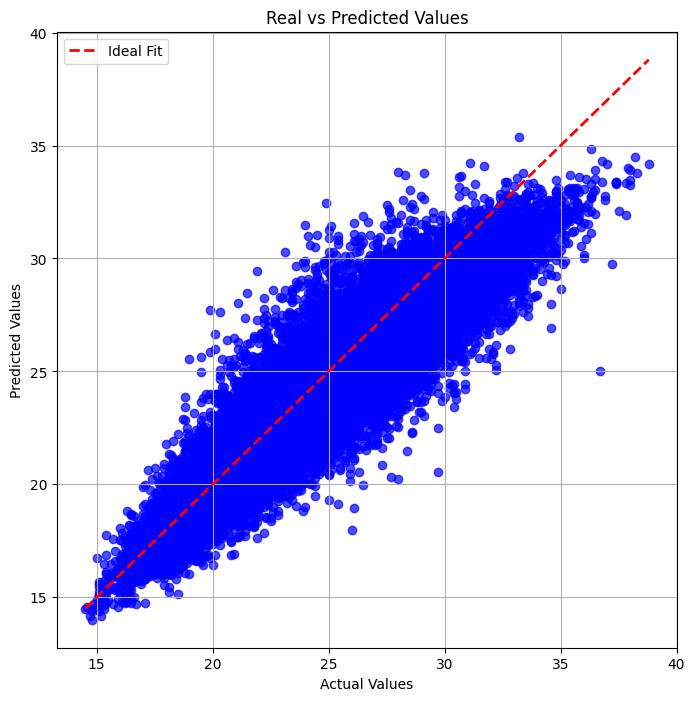

In [19]:
plot_real_vs_predicted(X_valid, rnn_forecast, save='./images/models/cnn_lstm_temp_real_x_predicted.png')

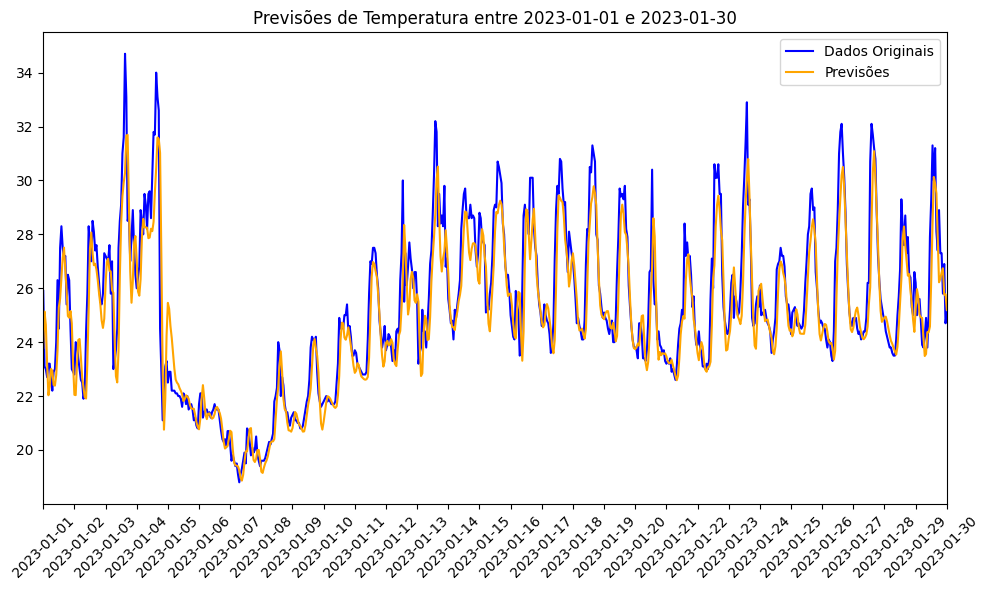

In [21]:
plot_timeseries_predictions(X_valid, rnn_forecast, time_valid, '2023-01-01', '2023-01-30', save='./images/models/cnn_lstm_temp_over_time.png')